# Wine tasting Notebook

#### author: A. Tomberg
#### date: 04/12/2019
##### In this notebook, we will analyze a set of wines, pulled from Kaggle website (https://www.kaggle.com/zynicide/wine-reviews). We will look at how the description from a sommalier can be used to cluster wines by similar features, and use these cluster to recommend wines that you may like based on a selected example.

In [1]:
import string
import collections

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import metrics
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#nltk.download('stopwords')
#nltk.download('punkt')

from joblib import dump, load

In [4]:
# load functions from my_functions notebook, that will be used to plot and extract data in this notebook

%run my_functions.ipynb

In [5]:
# load the data file. You need to unzip the zip file from GitHub and give the path to this file here

wine_data = pd.read_csv('winemag-data-130k-v2.csv/winemag-data-130k-v2.csv')

# use the .info() call to see what kind of columns you have in the file
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


In [6]:
# use the describe call to see some stats for a numerical column in the file. 
# For example the points (score of how tasty the wine is):
wine_data.points.describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [7]:
# preview the actual content of the file using the .head() call:
wine_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


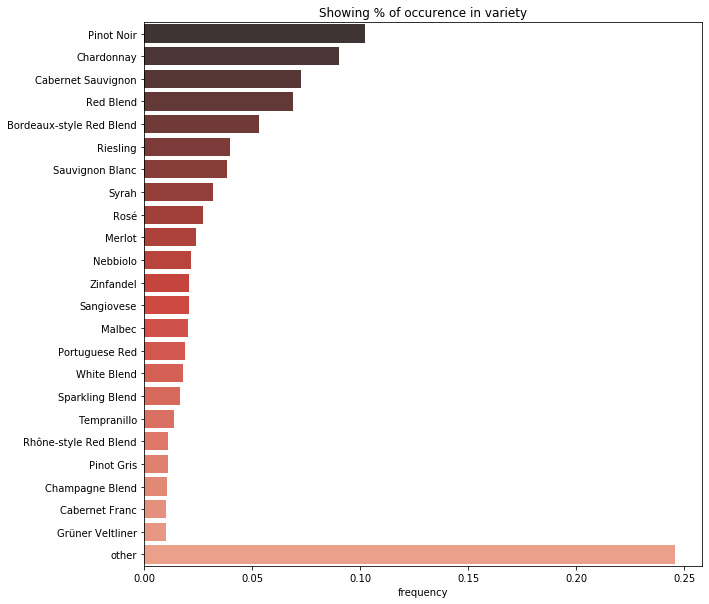

In [8]:
# Plot what kind of wines are found in the set
# N.B. plot_frequency_of_occurence() expects 1 word per row in selected column

plot_frequency_of_occurence(wine_data, 'variety')

Now that we have checked what kind of information we have in the dataset, we know that each wine has a description field, made out of text. We will use this desrciption to create a "fingerprint" for each entry in the set, then cluster wines using these fingerprints. <br>
Creating a fingerprint can be separated into 2 steps:<br>
1) split the sentences describing each wine into a list of words <br>
2) vectorize these lists (convert list of words into vectors of zeros and ones) so they can be used as input for the machine elarning algorithm (clustering)

In [9]:
# parse the description sentences for each wine into a list of words that can be used for clustering
wine_data['parsed_descr'] = wine_data['description'].apply(parse_decription)

In [ ]:
# we can save the csv file with new information in it for later use:
wine_data.to_csv(r'parsed_data.csv')

# we can then load this file back into memory if we want to work with it.
wine_data_parsed = pd.read_csv('parsed_data.csv')

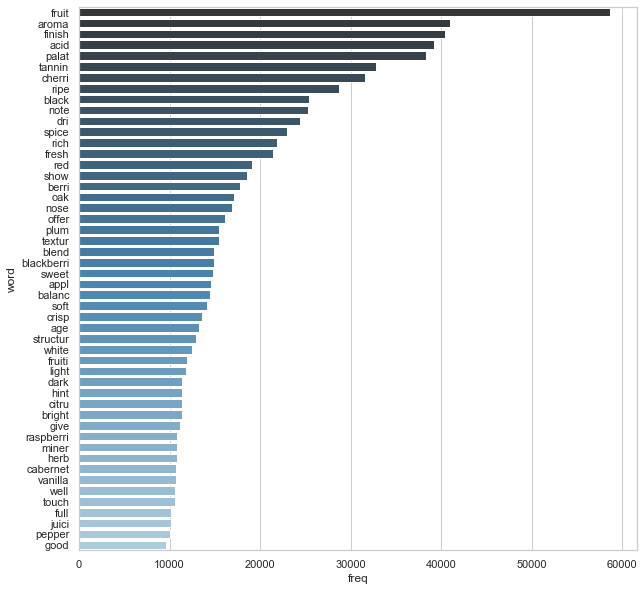

In [10]:
# let's check what are the most frequent words in our vocabulary
m = plot_freq_words(wine_data, 'parsed_descr', how_many = 50)

Below, we will take the parsed lists of words and vectorize them to create the input for the clustering algorithm:

In [11]:
# 1) define words that you don't want to use in the vectorization (words that are not useful for clustering):
stop_words = set(stopwords.words('english'))
stop_words.update(["drink", "now", "wine", "flavor", "flavors"])


In [12]:
# 2) create a vector representation of descriptions
vectorizer = TfidfVectorizer(lowercase=True, tokenizer=parse_decription, stop_words=stop_words, max_df=50000, min_df=500, max_features=None, analyzer='word')
tfidf_model = vectorizer.fit_transform(wine_data['description'])


C:\Users\annat\Anaconda3\envs\booze\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'nt', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
# save vectorizer for later
dump(tfidf_model, 'tfidf_model.joblib') 

['tfidf_model.joblib']

In [14]:
# load saved vectorizer
tfidf_model = load('tfidf_model.joblib') 

print("n_samples: %d, n_features: %d" % tfidf_model.shape)

n_samples: 129971, n_features: 852


We are ready to do the clustering. Here we will use a K means clustering approach as implemented in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [15]:
# Do the actual clustering

do_mini_batches = True
how_many_clusters = 6


if do_mini_batches:
    km = MiniBatchKMeans(n_clusters=how_many_clusters, init='k-means++', n_init=100,
                         init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=how_many_clusters, init='k-means++', max_iter=100, n_init=10)

print("Clustering data with %s" % km)
km.fit(tfidf_model);

Clustering data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=6, n_init=100, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)


In [16]:
# save the clustering model for later:
dump(km, 'wine_kmeans.joblib') 

['wine_kmeans.joblib']

In [ ]:
# load saved model into memory:
km=load('wine_kmeans.joblib') 

The clustering grouped the wines into 6 clusters based on their descriptions. We can now add this information to our dataset and analyze what kind of wines ended up in each cluster.

In [17]:
# add a cluster column to the wine dataset:

wine_data["cluster"] = ""

for idx, label in enumerate(km.labels_):
    wine_data.at[idx,"cluster"] = label

In [18]:
wine_data.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,parsed_descr,cluster
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"[aroma, includ, tropic, fruit, broom, brimston...",1
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"[ripe, fruiti, smooth, still, structur, firm, ...",2
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"[tart, snappi, lime, flesh, rind, domin, green...",1
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"[pineappl, rind, lemon, pith, orang, blossom, ...",1
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"[much, like, regular, bottl, come, across, rat...",0
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,"[blackberri, raspberri, aroma, show, typic, na...",4
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,"[bright, inform, red, open, aroma, candi, berr...",4
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,"[dri, restrain, offer, spice, profus, balanc, ...",0
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,"[savori, dri, thyme, note, accent, sunnier, pr...",1
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,"[great, depth, fresh, appl, pear, fruit, touch...",3


In [19]:
my_clusters = create_clusters_from_dataframe(wine_data, number_of_clusters = 6)

I created 6 clusters.


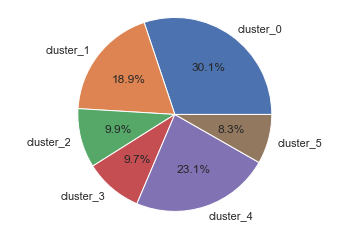

In [20]:
# let's look at how big the clusters are

sizes = [c.shape[0] for c in my_clusters]
labels = ['cluster_'+str(i) for i in range(len(my_clusters))]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False)
ax1.axis('equal')
plt.show()

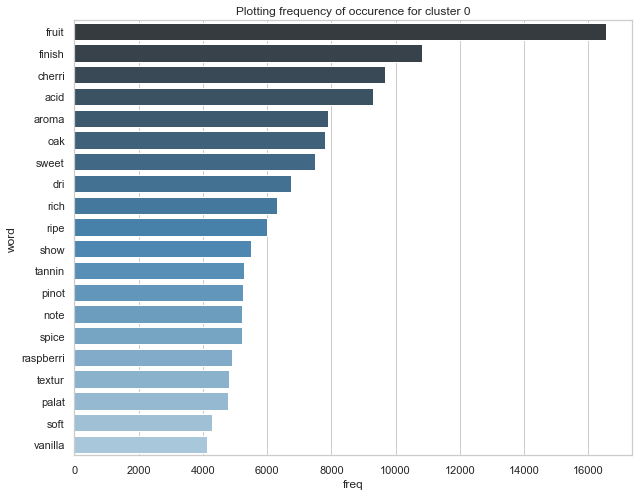

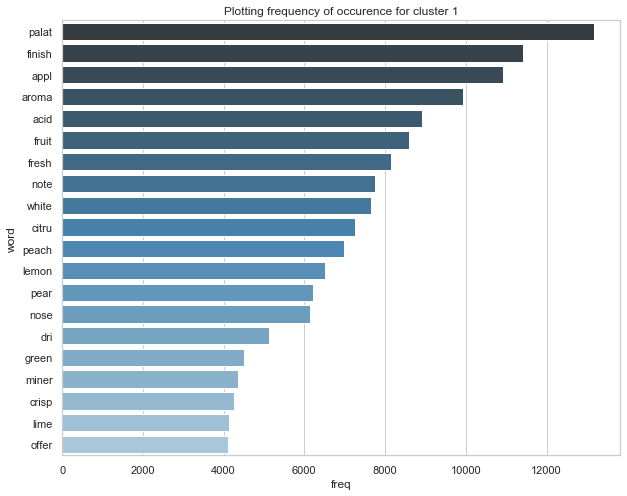

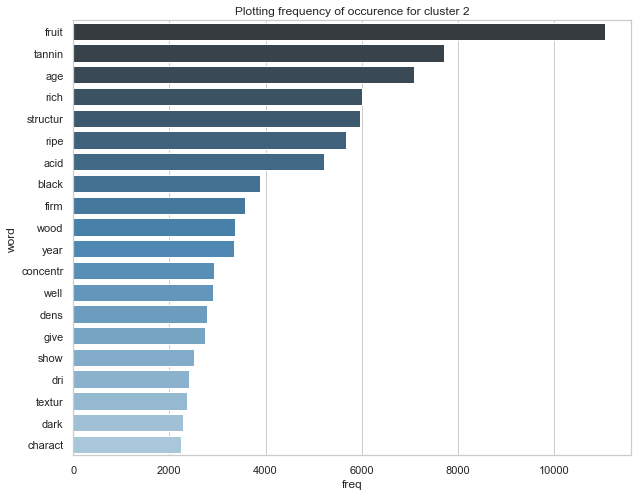

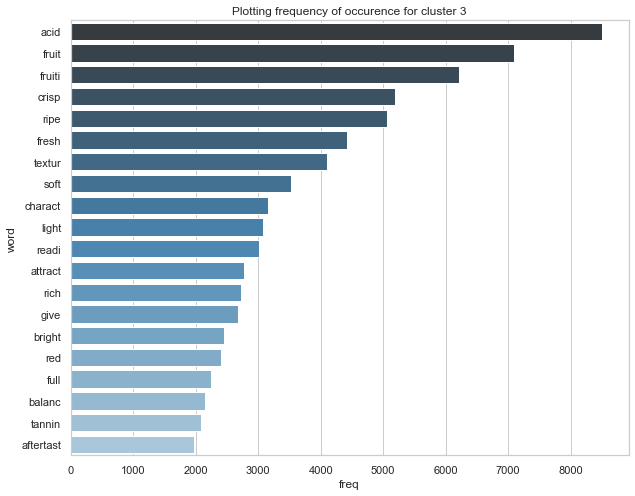

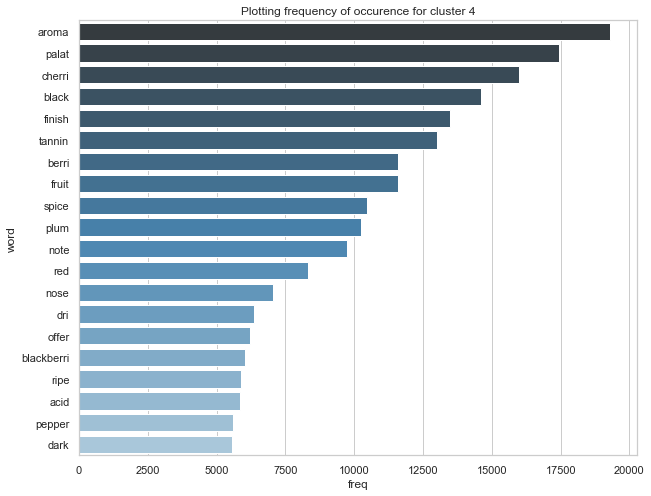

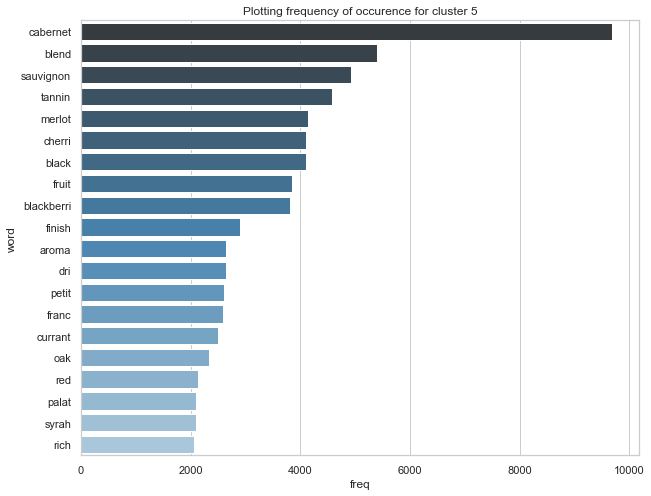

In [21]:
# for each cluster, which words are the most frequent? 
most_frequent_words = list()

i = 0
for c in my_clusters : 
    most_frequent_words.append(plot_freq_words(c, 'parsed_descr', how_many = 20, size = (10,8), \
                    title = 'Plotting frequency of occurence for cluster '+ str(i) ))
    i = i+1

CLUSTER 0


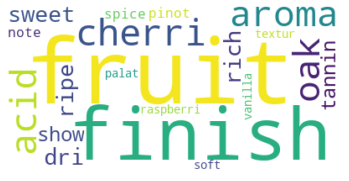

CLUSTER 1


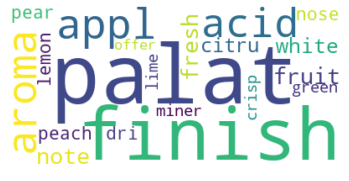

CLUSTER 2


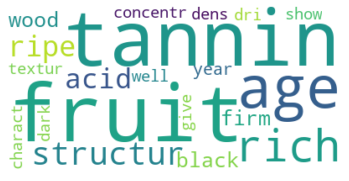

CLUSTER 3


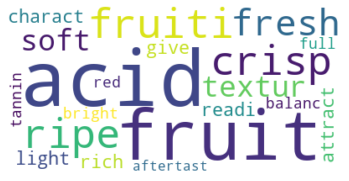

CLUSTER 4


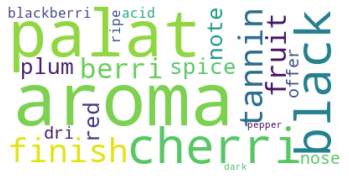

CLUSTER 5


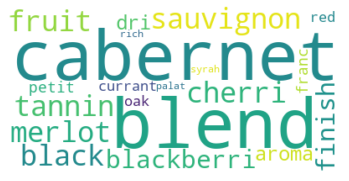

In [22]:
# Generate a word cloud image for each cluster:

for i in range(len(my_clusters)):
    text = " ".join(list(most_frequent_words[i].word))
    print('CLUSTER '+str(i))
    draw_word_cloud(text)

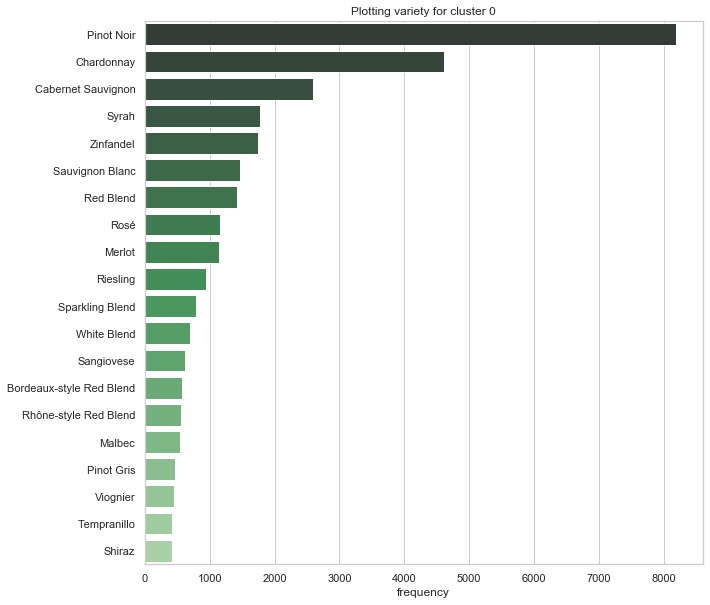

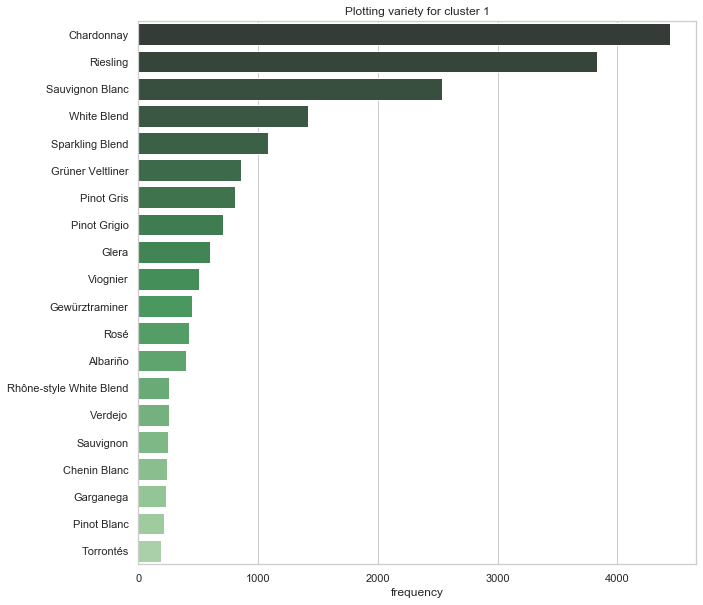

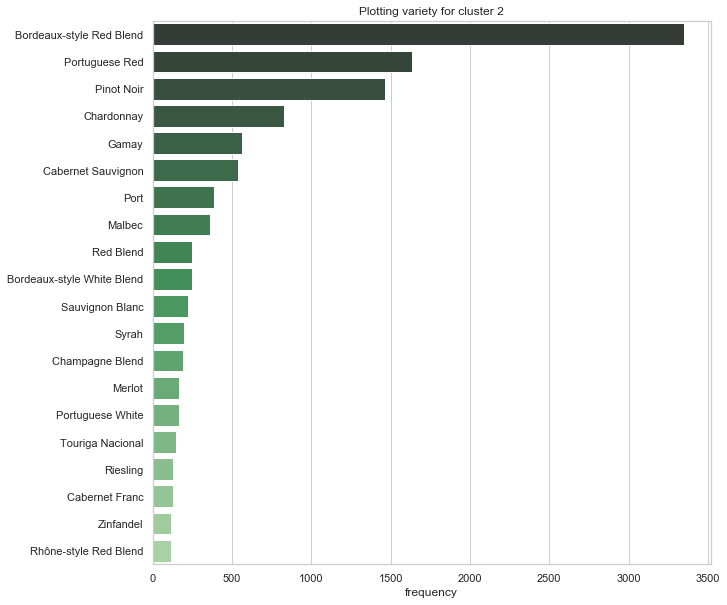

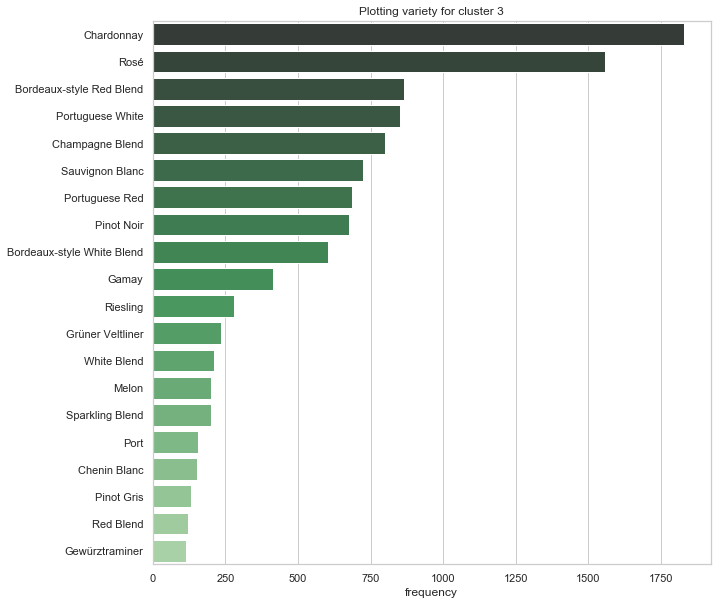

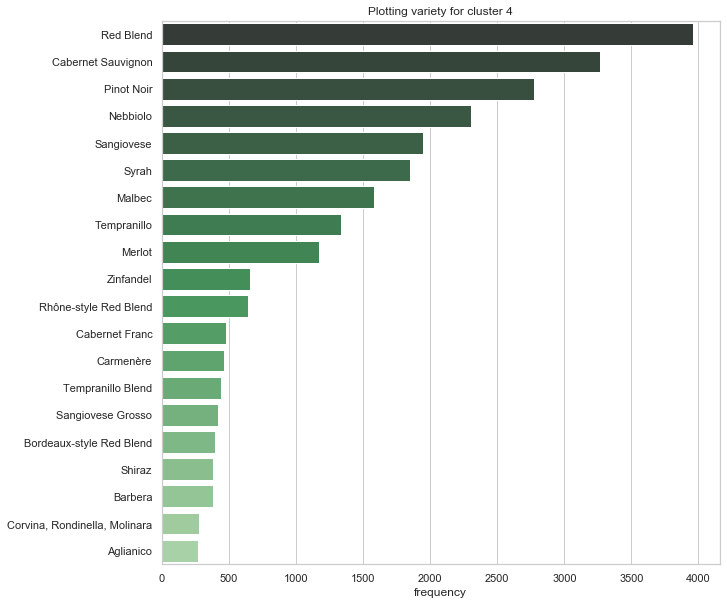

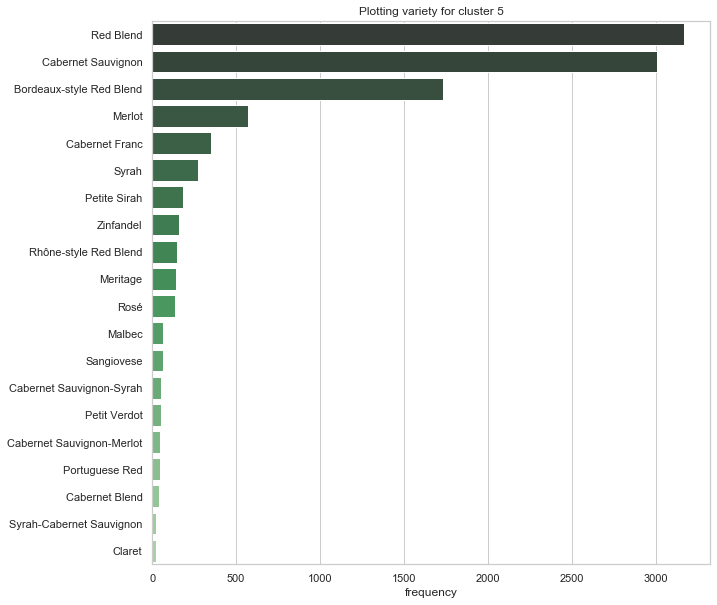

In [23]:
# which variety is the most frequent in each cluster? 

i = 0
for c in my_clusters : 
    (plot_variety_in_cluster(c, n = 20, \
                    title = 'Plotting variety for cluster '+ str(i) ))
    i = i+1


In [ ]:
# save the newly acquired data into a csv file for later.
wine_data.to_csv(r'clustered_data.csv')

### NOW LET'S SEE WHAT YOU LIKE  :)

We're going to vectorize the descriptions in each cluster, then compute a similarity matrix. Using this matrix, we can find nearest neighbours to a selected wine, and be able to recommend another wine to try based on preference.

In [ ]:
# load clusters from file
wine_data = pd.read_csv('clustered_data.csv')
my_clusters = create_clusters_from_dataframe(wine_data, number_of_clusters = 6)

In [24]:
# 1) define words that you don't want to use:
stop_words = set(stopwords.words('english'))
stop_words.update(["drink", "now", "wine", "flavor", "flavors"])

# 2) initiate vectorzer
vectorizer = CountVectorizer(lowercase=True, tokenizer=parse_decription, stop_words=stop_words, analyzer='word', max_features=100)

In [25]:
# 3) vectorze using counts
vectorizers = list()

count = 0
for c in my_clusters:
    tfidf = vectorizer.fit_transform(c.description)
    print('Cluster ', count, " n_samples: %d, n_features: %d" % tfidf.shape)
    vectorizers.append(tfidf)
    count = count+1


C:\Users\annat\Anaconda3\envs\booze\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'nt', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster  0  n_samples: 39158, n_features: 100
Cluster  1  n_samples: 24586, n_features: 100
Cluster  2  n_samples: 12858, n_features: 100
Cluster  3  n_samples: 12571, n_features: 100
Cluster  4  n_samples: 30070, n_features: 100
Cluster  5  n_samples: 10728, n_features: 100


In [26]:
# save vectorizers for later
count = 0
for v in vectorizers:
    dump(v, 'vectorizer_'+str(count)+'.joblib') 
    count = count+1

In [27]:
# load saved vectorizers

vectorizers = list()

for c in range(len(my_clusters)):
    vectorizers.append(load('vectorizer_'+str(c)+'.joblib')) 
    

In [28]:
# compute similarity matrices for each cluster
similarity_scores = list()
for v in vectorizers:
    similarity_scores.append(cosine_similarity(v.toarray()))


MemoryError: Unable to allocate array with shape (12858, 12858) and data type float64

In [ ]:
# finds the first index of the wine wiht search found in title    
wine_tag = 'Stoneleigh'
#wine_tag = 'Zinfandel'

idx_in_data, which_cluster, idx = get_index_from_title(wine_tag, wine_data, my_clusters)

if idx_in_data >= 0:
    w = wine_data.loc[idx_in_data]
    
    print('Title:', w.title)
    print('Country:', w.country)
    print('Variety:', w.variety)
    print(w.description)

In [ ]:
# find 5 similar wines to the selected one
similar = list(enumerate(similarity_scores[which_cluster][idx])) #accessing the row corresponding to given wine to find all the similarity scores, enumerating over it
sorted_similar = sorted(similar,key=lambda x:x[1],reverse=True)[1:]

print("Top 5 similar wines to "+w.title+" are:\n")

best_matches = [idx]
for element in sorted_similar[:5]:
    best_matches.append(element[0])
    
best = (my_clusters[which_cluster]).loc[best_matches]
best = best[['title', 'country','variety','description', 'price']].copy()

best

And we're done!